# Energy consumption prediction
* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 87472

In [1]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import lightgbm as lgb
from pprint import pprint

import linear_model_tests as lmt
import decision_tree_opt as dto
import Data_viz as dv
%reload_ext autoreload
%autoreload 2

lin_mod = lmt.Test()
opt_tree = dto.Parameters()
viz = dv.Graphs()

C:\Users\matti\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## DATA EXPLORATION

In [2]:
data = pd.read_csv("energydata_complete.csv", parse_dates=['date'])
data = data.dropna()
names = ["date","appliance_wh", "light_wh","kitchen_celsius","kitchen_hum_perc",
        "living_celsius","living_hum_perc","laundry_celsius","laundry_hum_perc","office_celsius","office_hum_perc",
         "bathroom_celsius","bathroom_hum_perc","portico_celsius","portico_hum_perc","ironing_celsius","ironing_hum_perc",
         "teen_celsius","teen_hum_perc","parents_celsius","parents_hum_perc","cws_celsius","cws_pressure","cws_hum_perc",
         "cws_wind","cws_visibility","cws_dew_point","rv1","rv2" ]

data = data.rename(columns = dict(zip(data.columns, names)))
data = data.drop_duplicates(data.columns, keep = "last")

586, 170, 70, 21


(19580, 27)

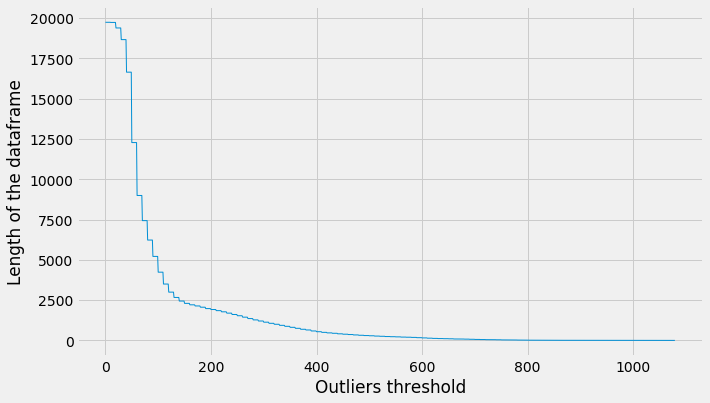

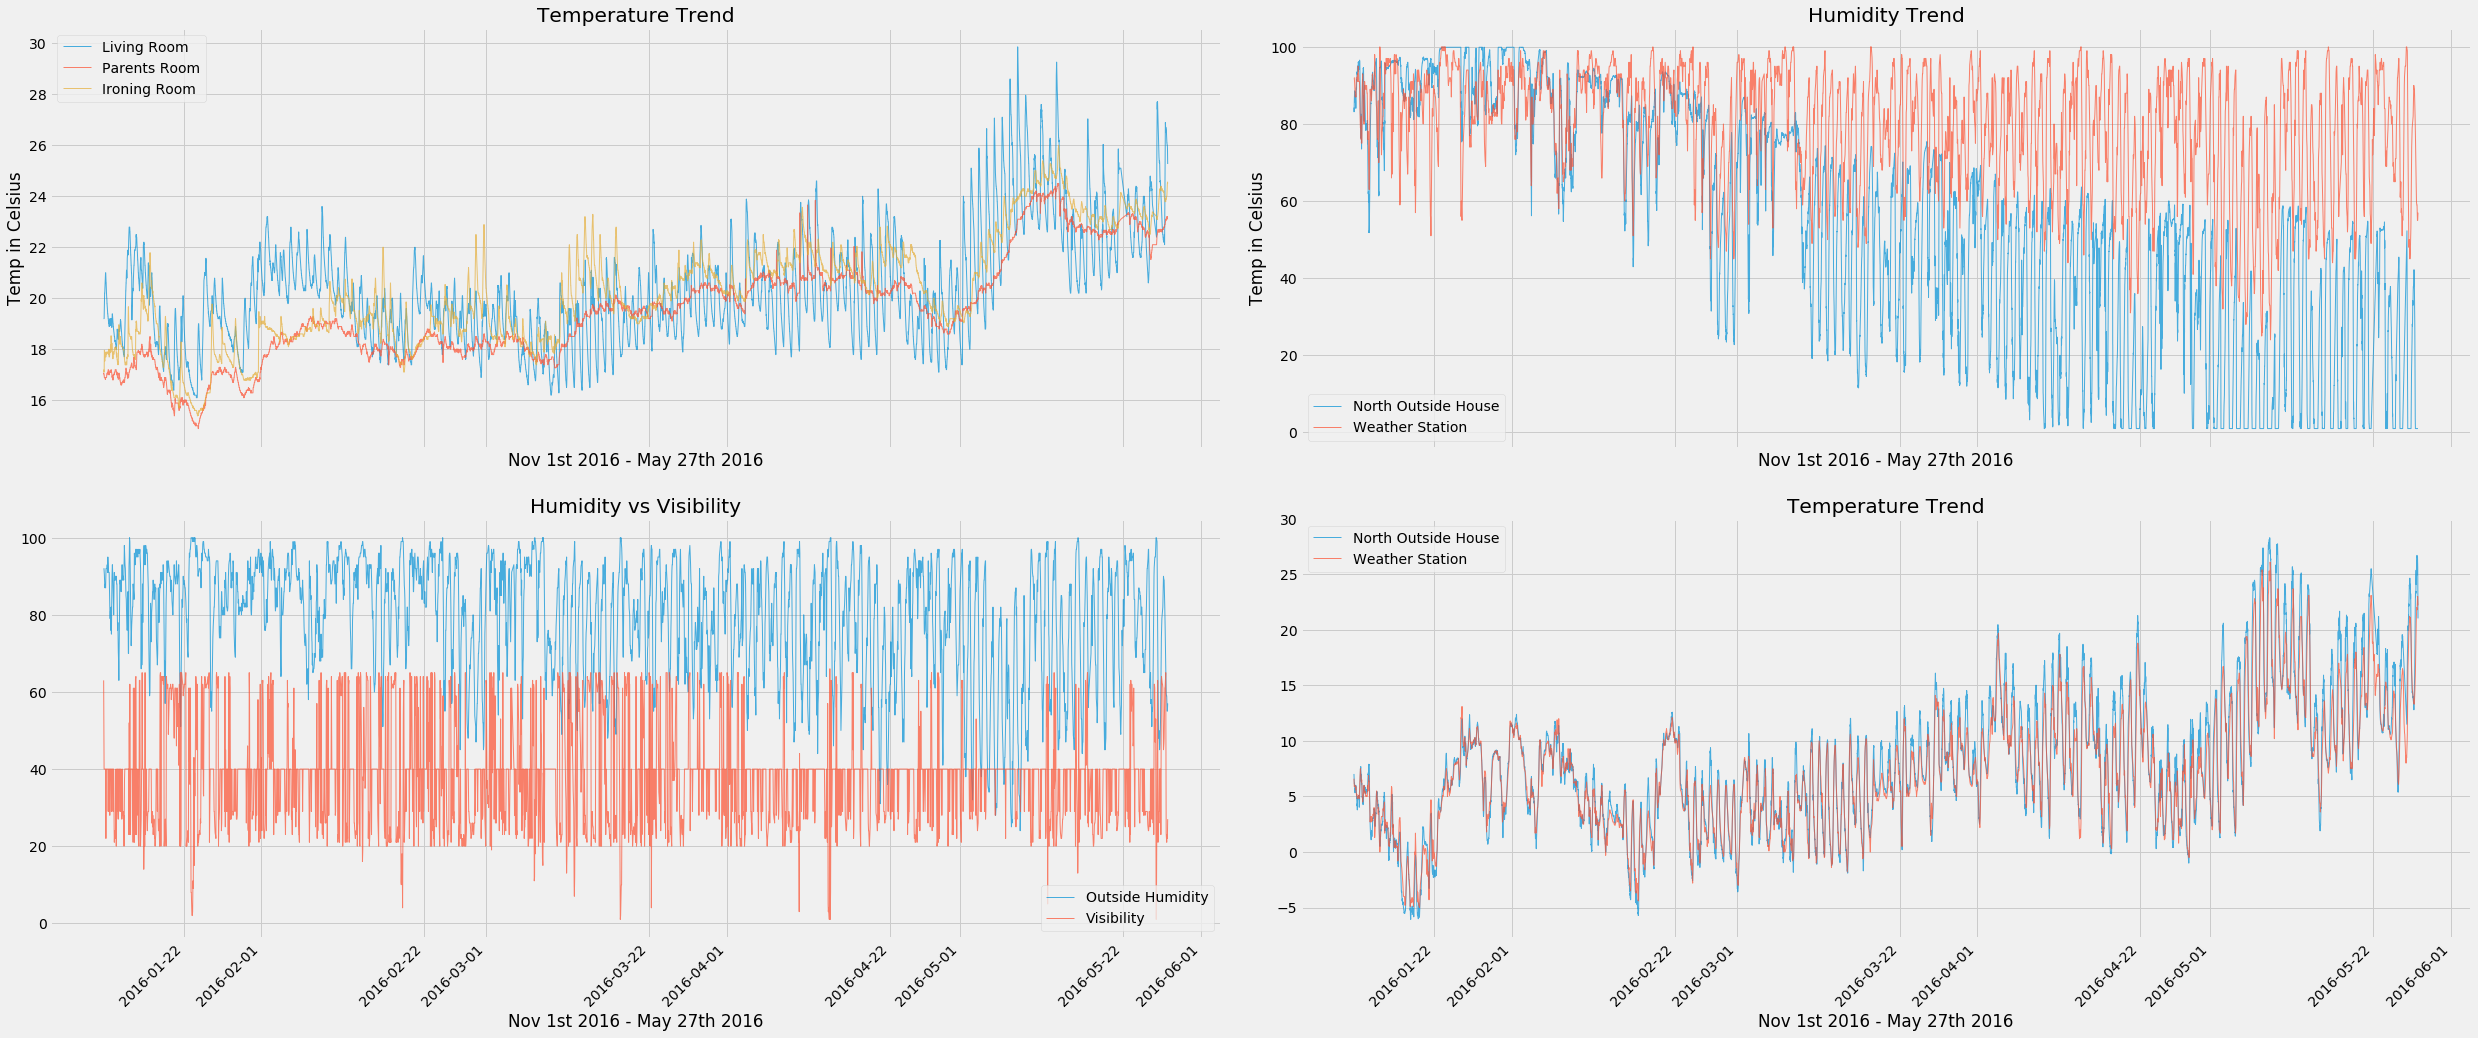

In [3]:
lengs = [ len(data) - len( data.drop(data[(data.appliance_wh > x)].index) )  for x in range(max(data.appliance_wh)) ]
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,6))
plt.plot(range(len(lengs)), lengs, linewidth = 1)
plt.xlabel('Outliers threshold'); plt.ylabel('Length of the dataframe')
print(lengs[399], lengs[599], lengs[699], lengs[789], sep = ", ")
viz.plot_1(data)
data = data.drop(data[(data.appliance_wh > 600)|(data.appliance_wh < 0)].index)
data = data.reset_index()
data = data.drop(["index", "light_wh", "date"], axis = 1)
data.shape

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC5BA70C08>,
      dtype=object)

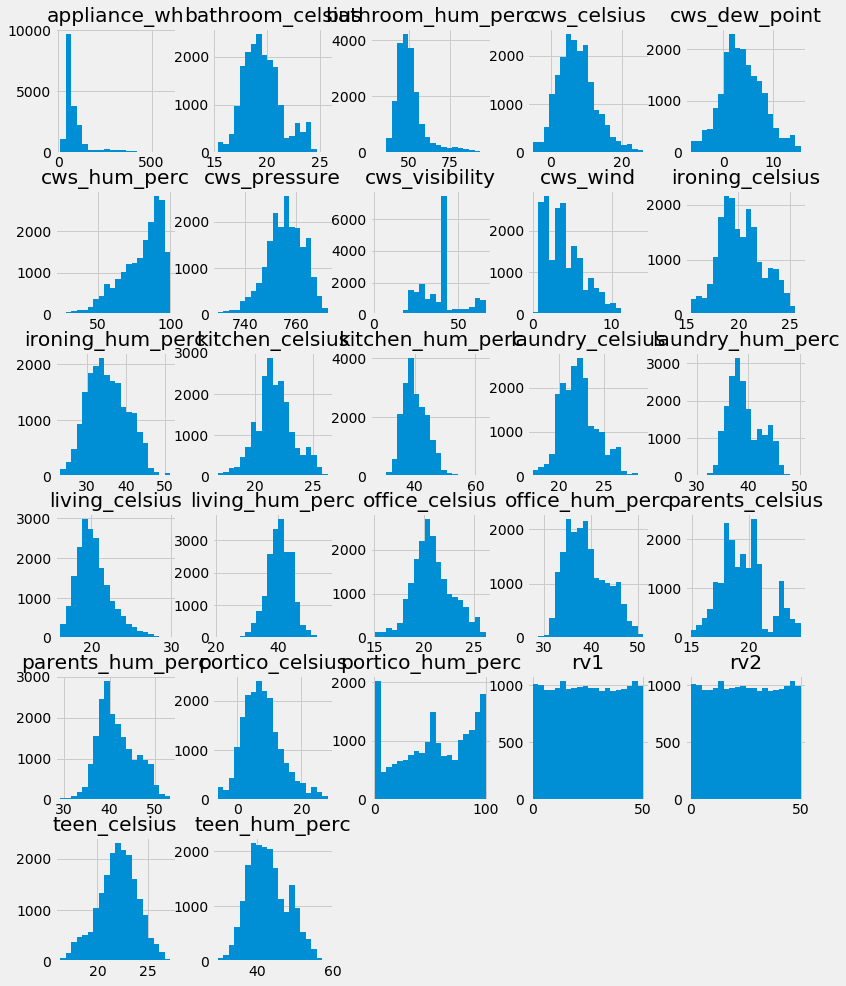

In [4]:
# Histogram of all the features to understand the distribution
plt.style.use('fivethirtyeight')
data.hist(bins = 20 , figsize= (12,16))

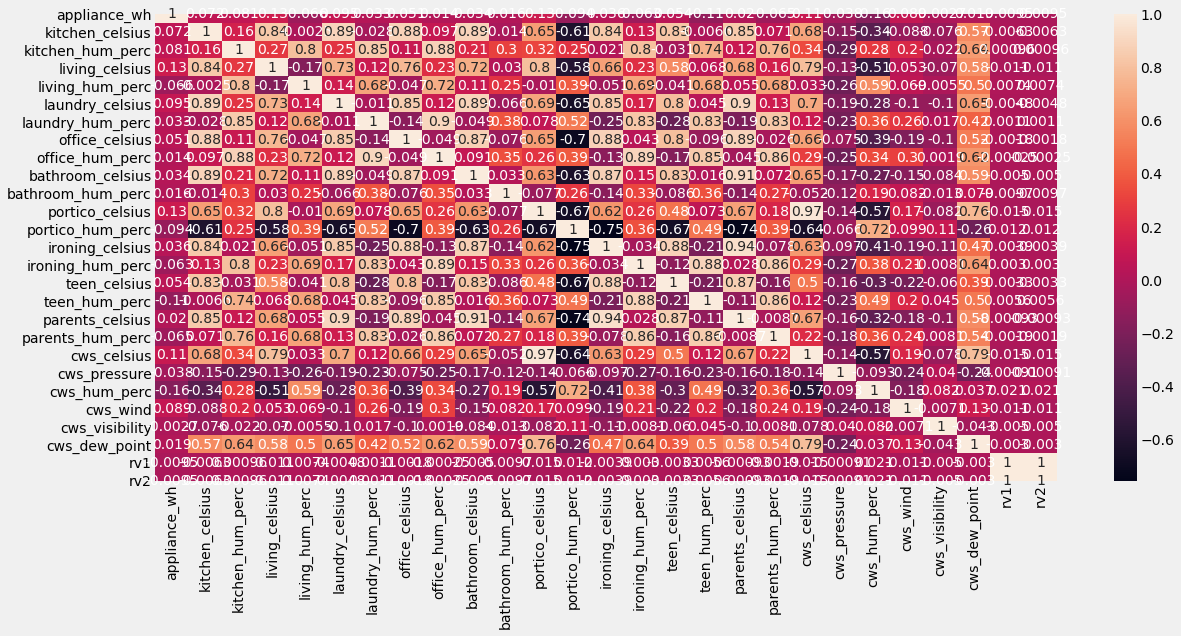

In [5]:
plt.figure(figsize = (18,8))
corr = data.corr()
sns.heatmap(corr, annot = True)

### Target, Features and Train Size
Set the target and the features matrices, with the train size equal to the $3/4$ of the sample size

In [6]:
X = data.drop("appliance_wh", axis = 1).values
y = data.appliance_wh
y_log = np.log(data.appliance_wh)

X = X.reshape( (len(X), len(X[0])))
y = y.values.reshape( len(y), 1)
y_log = y_log.values.reshape( len(y), 1)
print(y.shape, X.shape)

train_size = int(len(X)*0.75)
X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]
y_train_tree = y_log[:train_size]
y_test_tree  = y_log[train_size:]
print(train_size, len(X) - train_size)

(19580, 1) (19580, 26)
14685 4895


## LINEAR MODEL

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train)

y_pred = model.predict(X)

print("R^2 = ", round(r2_score(y, y_pred), 5))
print("MSE:", round(mean_squared_error(y, y_pred), 5))
print()
lasso = lin_mod.lasso(data, X, y)
print()
recursive = lin_mod.recurs_elimin(data, X, y)

R^2 =  0.14897
MSE: 6504.40011

Reducing features with LASSO 
	 ## Remaining features: 15 
	 ## R^2 after reduction: 0.20226

Reducing features with Recursive Feature Elimination 
	 ## Remaining features: 14 
	 ## R^2 after reduction: 0.19309


## POLYNOMIAL MODEL

In [8]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
features_polynomial = poly.fit_transform(X_train)

model_2 = LinearRegression(fit_intercept = True)
model_2.fit(features_polynomial, y_train)

y_pred_2 = model_2.predict( poly.transform(X) )

print("R^2 = ", round(r2_score(y, y_pred_2), 5) )
print("MSE:", round(mean_squared_error(y, y_pred_2), 5))

R^2 =  0.06331
MSE: 7159.09984


## DECISION TREE REGRESSOR

In [34]:
decisiontree = DecisionTreeRegressor()
model_tree = decisiontree.fit(X_train, y_train_tree)
tree_pred = model_tree.predict(X_test)

tree_par = opt_tree.evaluate(y_test_tree, tree_pred)
tree_imp = opt_tree.dtr_importance(data, model_tree)
print("Parameteres currently in use:")
pprint(decisiontree.get_params())

Model Performance
MAE: 0.70257
MSE: 0.83422
Variance: 0.44119
Accuracy: 82.18 %

                     values
living_celsius     0.097272
teen_hum_perc      0.075447
laundry_celsius    0.056362
teen_celsius       0.053160
bathroom_hum_perc  0.052332

Parameteres currently in use:
{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}


### Parameter tuning for Decision Tree

In [35]:
tree_tuned = DecisionTreeRegressor(ccp_alpha = 1, criterion = "mse", max_depth = 2,
                                   max_features = 13, max_leaf_nodes = 4, min_impurity_decrease = 0.009,
                                   min_impurity_split = 0.446, min_samples_leaf = 0.1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.2, random_state = 529, splitter = "random")
model_tuned = tree_tuned.fit(X_train, y_train_tree)
tuned_pred = model_tuned.predict(X_test)

tuned_par = opt_tree.evaluate(y_test_tree, tuned_pred)

Model Performance
MAE: 0.38582
MSE: 0.29281
Variance: 0.0
Accuracy: 91.48 %



### AdaBoosting and Bagging of the Tree Regressor

In [36]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator = tree_tuned, loss = "linear", random_state = 981)
boost_model = adaboost.fit(X_train, y_train_tree)
adaboost_pred = boost_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test_tree, adaboost_pred)

Model Performance
MAE: 0.46572
MSE: 0.32687
Variance: 0.0
Accuracy: 89.13 %



In [37]:
from sklearn.ensemble import BaggingRegressor

bagged = BaggingRegressor(base_estimator = tree_tuned)
bagg_model = bagged.fit(X_train, y_train_tree)
bagg_pred = bagg_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test_tree, bagg_pred)

Model Performance
MAE: 0.3857
MSE: 0.29287
Variance: 0.0
Accuracy: 91.48 %



## RANDOM FOREST REGRESSOR

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 1234)
rf_model = rf.fit(X_train, y_train_tree)
rf_pred = rf.predict(X_test)

rf_par = opt_tree.evaluate(y_test_tree, rf_pred)
rf_imp = opt_tree.dtr_importance(data, rf_model)
print("Parameters currently in use:")
pprint(rf.get_params())

Model Performance
MAE: 0.58701
MSE: 0.48287
Variance: 0.12586
Accuracy: 84.6 %

                     values
living_celsius     0.099477
teen_hum_perc      0.069520
parents_hum_perc   0.063291
kitchen_hum_perc   0.057107
bathroom_hum_perc  0.052009

Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


### Selection of the 8 most important features

In [14]:
imp_feats = ["living_celsius", "teen_hum_perc", "parents_hum_perc", "kitchen_hum_perc",
             "bathroom_hum_perc", "laundry_hum_perc", "teen_celsius", "portico_hum_perc"]
feat_drop = [x for x in data.columns if x not in imp_feats]

X_rf = data.drop(feat_drop, axis = 1).values
X_train_rf =  X_rf[:train_size]
X_test_rf = X_rf[train_size:]

### Parameter tuning for Random Forest Regressor

Chunk 1: Parameters are chosen after RandomizedSearchCV

In [42]:
rf_tuned = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False)
model_rf_tuned = rf_tuned.fit(X_train_rf, y_train_tree)
rf_tuned_pred = model_rf_tuned.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test_tree, rf_tuned_pred)

Model Performance
MAE: 0.52388
MSE: 0.39758
Variance: 0.09425
Accuracy: 86.17 %



Chunk 2: Parameters are chosen after GridSearchCV

In [43]:
rf_tun_2 = RandomForestRegressor(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False)
model_rf_tun_2 = rf_tun_2.fit(X_train_rf, y_train_tree)
rf_tun_2_pred = model_rf_tun_2.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test_tree, rf_tun_2_pred)

Model Performance
MAE: 0.52035
MSE: 0.3926
Variance: 0.09215
Accuracy: 86.24 %



## Forest with ```LightGBM```

In [44]:
lgb_train = lgb.Dataset(X_train_rf, y_train_tree)
lgb_eval = lgb.Dataset(X_test_rf, y_test_tree, reference = lgb_train)

forest = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ['l2', 'l1'],
                           num_leaves = 300, max_depth = 500, learning_rate = 0.0001, num_iterations = 600,
                           feature_fraction = 0.9, bagging_fraction = 0.8, bagging_freq = 5, verbose = 0)

forest.fit(X_train_rf, y_train_tree)
for_pred = forest.predict(X_test_rf)

for_par = opt_tree.evaluate(y_test_tree, for_pred)

Model Performance
MAE: 0.4675
MSE: 0.34842
Variance: 0.08806
Accuracy: 87.95 %

